Basically experiment 47 but now we also use C-HMC and we try to reproduce the experiments.

In [1]:
import numpy as np
from numpy import zeros, eye, array, r_, diag, ones, log, zeros_like, pi, exp, log10, sort, quantile, linspace, vstack
from numpy import save
from numpy.random import randn, rand, randint, default_rng
from numpy.random import normal
from numpy import isfinite
from numpy.linalg import solve, det, inv, norm

import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict
import copy

from warnings import catch_warnings, filterwarnings

from autograd import jacobian, grad
import autograd.numpy as anp
from autograd.numpy.linalg import norm as norm_a
import autograd.scipy as asp
from autograd.scipy.stats import norm as ndist_a
import autograd as ag

from scipy.stats import multivariate_normal as MVN
from scipy.optimize import fsolve, bisect
from scipy.stats import norm as ndist
from scipy.stats import uniform as udist
from scipy.stats import beta as betadist
from scipy.linalg import qr
from scipy.special import gamma

from g_and_k_functions import GandK
from tangential_hug_functions import HugTangentialMultivariate
from RWM import RWM
from HMC.static_hmc import HMC
from utils import ESS_univariate, ESS

In [2]:
# True parameter
θ0 = np.array([3.0, 1.0, 2.0, 0.5])
n_latents = 50
nps = 3.0 # Scale of normal prior for G and K when using HMC (for differtiability)
ϵ = 1.0 #0.0001 #0.0001 #0.07 #2.0
d = 4 + n_latents

In [3]:
prangle_mcmc_samples = np.loadtxt('ManifoldSamplingR/gk_mcmc_samples2.txt', skiprows=1, usecols=range(1, 5))[1:, :]

# Computational Cost Table

In [7]:
def compare_computational_costs(ϵ_list, N, n_independent_runs, T=0.2, B=5):
    """Given a list of ϵ and a number of samples, it will aim to generate a similar table to Chang's."""
    # Now nest them based on the data points generated
    computational_cost     = {i: {
        'HUG': zeros_like(ϵ_list),
        'THUG': zeros_like(ϵ_list),
        'HMC': zeros_like(ϵ_list),
        'RWM': zeros_like(ϵ_list)
    } for i in range(n_independent_runs)}
    acceptance_probability = {i: {
        'HUG': zeros_like(ϵ_list),
        'THUG': zeros_like(ϵ_list),
        'HMC': zeros_like(ϵ_list),
        'RWM': zeros_like(ϵ_list)
    } for i in range(n_independent_runs)}
    ess                    = {i: {
        'HUG': zeros_like(ϵ_list),
        'THUG': zeros_like(ϵ_list),
        'HMC': zeros_like(ϵ_list),
        'RWM': zeros_like(ϵ_list)
    } for i in range(n_independent_runs)}
    # Set some seeds
    seeds  = {i: randint(1111, 9999) for i in range(n_independent_runs)}
    # Proposal for THUG
    q = MVN(zeros(d), eye(d))
    for j in range(n_independent_runs):
        for i, ϵ in enumerate(ϵ_list):
            # Create the correct set up
            GK = GandK(m=n_latents, epsilon=ϵ, parameter_prior='normal', kernel='normal', normal_prior_scale=nps)
            if i == 0:
                ystar = GK.data_generator(θ0, seed=seeds[j])
            GK.set_ystar(ystar)
            if i == 0:
                ξ0 = GK.find_point_on_manifold(max_iter=5000)
            print('Run {}, ϵ = {}, ystar mean = {}'.format(j, ϵ, ystar.mean()))
            # Sample HUG
            print('\t Sampling HUG')
            sHUG, aHUG, ngHUG = HugTangentialMultivariate(ξ0, T, B, N, 0.0, q, GK.log_abc_posterior, GK.Jf, method='qr', return_n_grad=True)
            # Sample THUG α=0.9
            print('\t Sampling THUG')
            sTHUG, aTHUG, ngTHUG = HugTangentialMultivariate(ξ0, T, B, N, 0.99, q, GK.log_abc_posterior, GK.Jf, method='qr', return_n_grad=True)
            # Prep HMC
            def dVdξ(ξ, μ= 5*ones(4), Σ=(nps**2)*eye(4), ystar=ystar, ϵ=ϵ, GK=GK):
                θ, z = ξ[:4], ξ[4:]
                dpdξ = r_[solve(Σ, θ - μ), z]
                dkdξ = GK.Jf_transpose(ξ) @ (GK.f(ξ) - ystar) / (ϵ**2)
                return dpdξ + dkdξ
            def V(ξ, μ= 5*ones(4), Σ=(nps**2)*eye(4), ystar=ystar, ϵ=ϵ, GK=GK):
                θ, z = ξ[:4], ξ[4:]
                m    = len(z)
                neg_log_prior  = -MVN(mean=μ, cov=Σ).logpdf(θ) -MVN(mean=zeros(m), cov=eye(m)).logpdf(z) 
                neg_log_kernel = 0.5*log(2*pi*(ϵ**2)) + norm(GK.f(ξ) - ystar)**2 / (2*(ϵ**2))
                return neg_log_prior + neg_log_kernel 
            # Sample HMC
            print("\t Sampling HMC")
            HMCsampler                = HMC(ξ0, N, eye(d), T, T/B)
            HMCsampler.neg_log_target = lambda ξ: V(ξ, ystar=ystar, ϵ=ϵ, GK=GK)
            HMCsampler.dVdq           = lambda ξ: dVdξ(ξ, ystar=ystar, ϵ=ϵ, GK=GK)
            sHMC, aHMC                = HMCsampler.sample()
            # Sample RWM
            print("\t Sampling RWM")
            sRWM, aRWM = RWM(ξ0, T/B, N, GK.log_abc_posterior)
            # Compute density values and ESS
            hug_density_values  = np.apply_along_axis(GK.log_abc_posterior, 1, sHUG)
            thug_density_values = np.apply_along_axis(GK.log_abc_posterior, 1, sTHUG)
            hmc_density_values  = np.apply_along_axis(GK.log_abc_posterior, 1, sHMC)
            rwm_density_values  = np.apply_along_axis(GK.log_abc_posterior, 1, sRWM)
            ess_hug             = ESS_univariate(hug_density_values)
            ess_thug            = ESS_univariate(thug_density_values)
            ess_hmc             = ESS_univariate(hmc_density_values)
            ess_rwm             = ESS_univariate(rwm_density_values)
            # Store computational cost
            computational_cost[j]['HUG'][i]  = log10((ngHUG + N + 1) / ess_hug)
            computational_cost[j]['THUG'][i] = log10((ngTHUG + N + 1) / ess_thug)
            computational_cost[j]['HMC'][i]  = log10((HMCsampler.Ngrad + N + 1) / ess_hmc)
            computational_cost[j]['RWM'][i]  = log10((N + 1) / ess_rwm)
            # Store acceptance probabilities
            acceptance_probability[j]['HUG'][i]  = aHUG.mean() * 100
            acceptance_probability[j]['THUG'][i] = aTHUG.mean() * 100
            acceptance_probability[j]['HMC'][i]  = aHMC.mean() * 100 
            acceptance_probability[j]['RWM'][i]  = aRWM.mean() * 100
            # Store ESS
            ess[j]['HUG'][i] = ess_hug
            ess[j]['THUG'][i] = ess_thug
            ess[j]['HMC'][i]  = ess_hmc
            ess[j]['RWM'][i]  = ess_rwm
    return computational_cost, acceptance_probability, ess


In [74]:
T = 0.2
B = 5
N = 10000
q = MVN(zeros(d), eye(d))

In [94]:
caption = "Computational cost per effective sample in log10 scale. Total computational cost for RWM is the total number of $f$ evaluations, for all other algorithms we sum to it the number of Jacobian computations. ESS was computed on the log posterior density of samples."

# Generate Latex Table
def generate_latex_table(cc, ap, ϵ_list, caption=caption):
    """Generates Chang's latex table."""
    # Check that `cc` and `ap` have the same keys
    assert set(cc.keys()) == set(ap.keys())
    new_dictionary = {key: zeros_like(ϵ_list) for key in cc2[0].keys()}
    for run_ix in cc2.keys():
        for alg in cc2[run_ix].keys():
            new_dictionary[alg] += cc2[run_ix][alg] / len(cc2.keys()) #* np.array(ap2[run_ix][alg] != 0, dtype=float) / len(cc2.keys())
    # Set ordered dictionary for comp cost
    cco = OrderedDict(new_dictionary)
    cco.update({'Tolerances': ϵ_list})
    cco.move_to_end('Tolerances', last=False)
#     for alg in cc.keys():
#         cco[alg] *= np.array(ap[alg] != 0, dtype=float)
    func = lambda alg, i: cco[alg][i] if cco[alg][i] != 0.0 else np.nan
    # Generate table
    string  = r'\begin{table}'
    string += "\n\t" + r'\begin{tabular}{ | l | l | l | l | l |}'
    string += "\n\t" + r'\hline'
    string += "\n\t" + "Tolerances & HUG & THUG & HMC & RWM \\\ \hline"
    for i, ϵ in enumerate(ϵ_list):
        row = "\n\t" + "{}  & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\ \hline".format(ϵ, func('HUG', i), func('THUG', i), func('HMC', i), func('RWM', i))
        string += row.replace('nan', '-')
    string += "\n\t" + r'\end{tabular}'
    string += "\n\t \caption{" + caption + "}"
    string += "\n" + r'\end{table}'
    return string

In [97]:
cc, ap, ess = compare_computational_costs([10.0, 1.0, 0.001], 10000, 2)

Run 0, ϵ = 10.0, ystar mean = 3.9187950399613105
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 0, ϵ = 1.0, ystar mean = 3.9187950399613105
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC


/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: overflow encountered in square
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:178: RuntimeWarning: overflow encountered in exp
  diag(b*((1+z**2)**(k-1))*(((18*k + 9)*(z**2) + 9)*exp(2*g*z) + (8*g*z**3 + (20*k + 10)*z**2 + 8*g*z + 10)*exp(g*z) + (2*k + 1)*z**2 + 1) / (5*(1 + exp(g*z))**2))
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:178: RuntimeWarning: invalid value encountered in multiply
  diag(b*((1+z**2)**(k-1))*(((18*k + 9)*(z**2) + 9)*exp(2*g*z) + (8*g*z**3 + (20*k + 10)*z**2 + 8*g*z + 10)*exp(g*z) + (2*k + 1)*z**2 + 1) / (5*(1 + exp(g*z))**2))
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:178: RuntimeWarning: overflow encountered in square
  diag(b*((1+z**2)**(k-1))*(((18*k + 9)*(z**2) + 9)*exp(2*g*z) + (8*g*z**3 

	 Sampling RWM
Run 0, ϵ = 0.001, ystar mean = 3.9187950399613105
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC


/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:175: RuntimeWarning: overflow encountered in power
  (1 + 0.8 * (1 - exp(-g * z)) / (1 + exp(-g * z))) * ((1 + z**2)**k) * z,
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: overflow encountered in power
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: invalid value encountered in true_divide
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:177: RuntimeWarning: overflow encountered in power
  b*z*((1+z**2)**k)*(1 + 9*exp(g*z))*log(1 + z**2) / (5*(1 + exp(g*z))),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:177: RuntimeWarning: invalid value encountered in true_divide
  b*z*((1+z**2)**k)*(1 + 9*exp(g*z))*lo

	 Sampling RWM
Run 1, ϵ = 10.0, ystar mean = 4.302713925145772
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 1, ϵ = 1.0, ystar mean = 4.302713925145772
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 1, ϵ = 0.001, ystar mean = 4.302713925145772
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC


/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:175: RuntimeWarning: overflow encountered in exp
  (1 + 0.8 * (1 - exp(-g * z)) / (1 + exp(-g * z))) * ((1 + z**2)**k) * z,
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:175: RuntimeWarning: invalid value encountered in true_divide
  (1 + 0.8 * (1 - exp(-g * z)) / (1 + exp(-g * z))) * ((1 + z**2)**k) * z,
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:175: RuntimeWarning: overflow encountered in power
  (1 + 0.8 * (1 - exp(-g * z)) / (1 + exp(-g * z))) * ((1 + z**2)**k) * z,
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: overflow encountered in power
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: overflow encountered in exp
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5

	 Sampling RWM


In [98]:
cc

{0: {'HUG': array([3.25346002, 3.0801392 , 3.975218  ]),
  'THUG': array([2.80603217, 3.02374205, 3.84082519]),
  'HMC': array([3.09012902, 4.84510424, 4.84510424]),
  'RWM': array([2.20106507, 4.00004343, 4.00004343])},
 1: {'HUG': array([2.92262965, 3.20934996, 3.72724132]),
  'THUG': array([2.83122534, 2.71507166, 3.1769217 ]),
  'HMC': array([2.54189233, 4.26778266, 4.84510424]),
  'RWM': array([2.26375377, 3.44854772, 4.00004343])}}

In [99]:
ap

{0: {'HUG': array([51.44, 50.19,  0.34]),
  'THUG': array([65.29, 66.49, 63.82]),
  'HMC': array([95.84,  0.  ,  0.  ]),
  'RWM': array([44.15,  0.  ,  0.  ])},
 1: {'HUG': array([50.84, 49.54,  6.26]),
  'THUG': array([65.33, 63.6 , 65.01]),
  'HMC': array([9.989e+01, 2.000e-02, 0.000e+00]),
  'RWM': array([44.34,  0.52,  0.  ])}}

In [100]:
def compute_avg_acceptance_probability_grid(ap):
    """Basically produces a plot similar to the one in BIP. 
    Aim: see how acceptance probability changes as epsilon decreases."""
    ap_avg = {alg: 0.0 for alg in ap[0].keys()}
    for run_index in ap.keys():
        for alg in ap[run_index].keys():
            ap_avg[alg] += ap[run_index][alg] / len(ap.keys())
    return ap_avg

In [101]:
compute_avg_acceptance_probability_grid(ap)

{'HUG': array([51.14 , 49.865,  3.3  ]),
 'THUG': array([65.31 , 65.045, 64.415]),
 'HMC': array([9.7865e+01, 1.0000e-02, 0.0000e+00]),
 'RWM': array([44.245,  0.26 ,  0.   ])}

In [103]:
from scipy.stats import wasserstein_distance

In [ ]:
wasserstein_distance()

In [9]:
ϵ_list = [10.0, 1.0, 0.1, 0.01, 0.001, 0.0001]
cc2, ap2, ess2 = compare_computational_costs(ϵ_list, 10000, 5)

Run 0, ϵ = 10.0, ystar mean = 3.3940804719885005
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM


/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/tensorflow_probability/python/__init__.py:74: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  warnings.warn(


Run 0, ϵ = 1.0, ystar mean = 3.3940804719885005
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 0, ϵ = 0.1, ystar mean = 3.3940804719885005
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC


/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: overflow encountered in square
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:178: RuntimeWarning: overflow encountered in exp
  diag(b*((1+z**2)**(k-1))*(((18*k + 9)*(z**2) + 9)*exp(2*g*z) + (8*g*z**3 + (20*k + 10)*z**2 + 8*g*z + 10)*exp(g*z) + (2*k + 1)*z**2 + 1) / (5*(1 + exp(g*z))**2))
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:178: RuntimeWarning: overflow encountered in square
  diag(b*((1+z**2)**(k-1))*(((18*k + 9)*(z**2) + 9)*exp(2*g*z) + (8*g*z**3 + (20*k + 10)*z**2 + 8*g*z + 10)*exp(g*z) + (2*k + 1)*z**2 + 1) / (5*(1 + exp(g*z))**2))
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:178: RuntimeWarning: invalid value encountered in true_divide
  diag(b*((1+z**2)**(k-1))*(((18*k + 9)*(z**2) + 9)*exp(2*g*z) + (8*g*z*

	 Sampling RWM
Run 0, ϵ = 0.01, ystar mean = 3.3940804719885005
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC


/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:175: RuntimeWarning: overflow encountered in power
  (1 + 0.8 * (1 - exp(-g * z)) / (1 + exp(-g * z))) * ((1 + z**2)**k) * z,
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: overflow encountered in power
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:177: RuntimeWarning: overflow encountered in power
  b*z*((1+z**2)**k)*(1 + 9*exp(g*z))*log(1 + z**2) / (5*(1 + exp(g*z))),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:157: RuntimeWarning: overflow encountered in power
  return a + b*(1 + 0.8 * (1 - exp(-g * z)) / (1 + exp(-g * z))) * ((1 + z**2)**k) * z
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_6316/3424426908.py:46: RuntimeWarning: invalid value encountered in matmul
  dkdξ = GK.Jf_transpose(ξ) @ (GK.f(ξ) - y

	 Sampling RWM
Run 0, ϵ = 0.001, ystar mean = 3.3940804719885005
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 0, ϵ = 0.0001, ystar mean = 3.3940804719885005
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 1, ϵ = 10.0, ystar mean = 3.3283897605452393
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC


/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:175: RuntimeWarning: overflow encountered in exp
  (1 + 0.8 * (1 - exp(-g * z)) / (1 + exp(-g * z))) * ((1 + z**2)**k) * z,
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:175: RuntimeWarning: invalid value encountered in true_divide
  (1 + 0.8 * (1 - exp(-g * z)) / (1 + exp(-g * z))) * ((1 + z**2)**k) * z,
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: overflow encountered in exp
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: invalid value encountered in multiply
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:177: RuntimeWarning: overflow encountered in exp
  b*z*((1+z**2)**k)*(1 + 9*exp(g*z))*log(1 + z

	 Sampling RWM
Run 1, ϵ = 1.0, ystar mean = 3.3283897605452393
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC


/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: overflow encountered in square
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:178: RuntimeWarning: overflow encountered in multiply
  diag(b*((1+z**2)**(k-1))*(((18*k + 9)*(z**2) + 9)*exp(2*g*z) + (8*g*z**3 + (20*k + 10)*z**2 + 8*g*z + 10)*exp(g*z) + (2*k + 1)*z**2 + 1) / (5*(1 + exp(g*z))**2))
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:178: RuntimeWarning: overflow encountered in square
  diag(b*((1+z**2)**(k-1))*(((18*k + 9)*(z**2) + 9)*exp(2*g*z) + (8*g*z**3 + (20*k + 10)*z**2 + 8*g*z + 10)*exp(g*z) + (2*k + 1)*z**2 + 1) / (5*(1 + exp(g*z))**2))
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: overflow encountered in multiply
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/U

	 Sampling RWM
Run 1, ϵ = 0.1, ystar mean = 3.3283897605452393
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 1, ϵ = 0.01, ystar mean = 3.3283897605452393
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 1, ϵ = 0.001, ystar mean = 3.3283897605452393
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 1, ϵ = 0.0001, ystar mean = 3.3283897605452393
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 2, ϵ = 10.0, ystar mean = 3.3127556362047335
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 2, ϵ = 1.0, ystar mean = 3.3127556362047335
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC


/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: overflow encountered in square
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:178: RuntimeWarning: overflow encountered in exp
  diag(b*((1+z**2)**(k-1))*(((18*k + 9)*(z**2) + 9)*exp(2*g*z) + (8*g*z**3 + (20*k + 10)*z**2 + 8*g*z + 10)*exp(g*z) + (2*k + 1)*z**2 + 1) / (5*(1 + exp(g*z))**2))
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:178: RuntimeWarning: overflow encountered in square
  diag(b*((1+z**2)**(k-1))*(((18*k + 9)*(z**2) + 9)*exp(2*g*z) + (8*g*z**3 + (20*k + 10)*z**2 + 8*g*z + 10)*exp(g*z) + (2*k + 1)*z**2 + 1) / (5*(1 + exp(g*z))**2))
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:178: RuntimeWarning: invalid value encountered in true_divide
  diag(b*((1+z**2)**(k-1))*(((18*k + 9)*(z**2) + 9)*exp(2*g*z) + (8*g*z*

	 Sampling RWM
Run 2, ϵ = 0.1, ystar mean = 3.3127556362047335
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC


/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:175: RuntimeWarning: overflow encountered in exp
  (1 + 0.8 * (1 - exp(-g * z)) / (1 + exp(-g * z))) * ((1 + z**2)**k) * z,
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:175: RuntimeWarning: invalid value encountered in true_divide
  (1 + 0.8 * (1 - exp(-g * z)) / (1 + exp(-g * z))) * ((1 + z**2)**k) * z,
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: overflow encountered in exp
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: invalid value encountered in multiply
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:177: RuntimeWarning: overflow encountered in exp
  b*z*((1+z**2)**k)*(1 + 9*exp(g*z))*log(1 + z

	 Sampling RWM
Run 2, ϵ = 0.01, ystar mean = 3.3127556362047335
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC


/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:175: RuntimeWarning: overflow encountered in power
  (1 + 0.8 * (1 - exp(-g * z)) / (1 + exp(-g * z))) * ((1 + z**2)**k) * z,
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: overflow encountered in power
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:177: RuntimeWarning: overflow encountered in power
  b*z*((1+z**2)**k)*(1 + 9*exp(g*z))*log(1 + z**2) / (5*(1 + exp(g*z))),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:178: RuntimeWarning: overflow encountered in power
  diag(b*((1+z**2)**(k-1))*(((18*k + 9)*(z**2) + 9)*exp(2*g*z) + (8*g*z**3 + (20*k + 10)*z**2 + 8*g*z + 10)*exp(g*z) + (2*k + 1)*z**2 + 1) / (5*(1 + exp(g*z))**2))
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:157: RuntimeWarning: 

	 Sampling RWM
Run 2, ϵ = 0.001, ystar mean = 3.3127556362047335
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 2, ϵ = 0.0001, ystar mean = 3.3127556362047335
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 3, ϵ = 10.0, ystar mean = 4.630832568850968
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 3, ϵ = 1.0, ystar mean = 4.630832568850968
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 3, ϵ = 0.1, ystar mean = 4.630832568850968
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC


/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:175: RuntimeWarning: overflow encountered in exp
  (1 + 0.8 * (1 - exp(-g * z)) / (1 + exp(-g * z))) * ((1 + z**2)**k) * z,
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:175: RuntimeWarning: invalid value encountered in true_divide
  (1 + 0.8 * (1 - exp(-g * z)) / (1 + exp(-g * z))) * ((1 + z**2)**k) * z,
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: overflow encountered in exp
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: invalid value encountered in multiply
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:177: RuntimeWarning: overflow encountered in exp
  b*z*((1+z**2)**k)*(1 + 9*exp(g*z))*log(1 + z

	 Sampling RWM
Run 3, ϵ = 0.01, ystar mean = 4.630832568850968
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC


/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_6316/3424426908.py:46: RuntimeWarning: overflow encountered in true_divide
  dkdξ = GK.Jf_transpose(ξ) @ (GK.f(ξ) - ystar) / (ϵ**2)


	 Sampling RWM
Run 3, ϵ = 0.001, ystar mean = 4.630832568850968
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 3, ϵ = 0.0001, ystar mean = 4.630832568850968
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 4, ϵ = 10.0, ystar mean = 3.3826303623435443
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 4, ϵ = 1.0, ystar mean = 3.3826303623435443
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 4, ϵ = 0.1, ystar mean = 3.3826303623435443
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC


/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: overflow encountered in exp
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: invalid value encountered in multiply
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: overflow encountered in square
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:177: RuntimeWarning: overflow encountered in exp
  b*z*((1+z**2)**k)*(1 + 9*exp(g*z))*log(1 + z**2) / (5*(1 + exp(g*z))),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:177: RuntimeWarning: invalid value encountered in multiply
  b*z*((1+z**2)**k)*(1 + 9*exp(g*z))*log(1 + z**2)

	 Sampling RWM
Run 4, ϵ = 0.01, ystar mean = 3.3826303623435443
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC


/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:175: RuntimeWarning: overflow encountered in power
  (1 + 0.8 * (1 - exp(-g * z)) / (1 + exp(-g * z))) * ((1 + z**2)**k) * z,
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: overflow encountered in power
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:177: RuntimeWarning: overflow encountered in power
  b*z*((1+z**2)**k)*(1 + 9*exp(g*z))*log(1 + z**2) / (5*(1 + exp(g*z))),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:178: RuntimeWarning: overflow encountered in power
  diag(b*((1+z**2)**(k-1))*(((18*k + 9)*(z**2) + 9)*exp(2*g*z) + (8*g*z**3 + (20*k + 10)*z**2 + 8*g*z + 10)*exp(g*z) + (2*k + 1)*z**2 + 1) / (5*(1 + exp(g*z))**2))
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:157: RuntimeWarning: 

	 Sampling RWM
Run 4, ϵ = 0.001, ystar mean = 3.3826303623435443
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM
Run 4, ϵ = 0.0001, ystar mean = 3.3826303623435443
	 Sampling HUG
	 Sampling THUG
	 Sampling HMC
	 Sampling RWM


In [95]:
print(generate_latex_table(cc, ap, ϵ_list))

\begin{table}
	\begin{tabular}{ | l | l | l | l | l |}
	\hline
	Tolerances & HUG & THUG & HMC & RWM \\ \hline
	10.0  & 3.14 & 3.22 & 3.07 & 2.18 \\ \hline
	1.0  & 3.12 & 3.21 & 3.62 & 2.98 \\ \hline
	0.1  & 3.31 & 3.25 & 3.88 & 2.75 \\ \hline
	0.01  & 3.71 & 3.18 & 3.88 & 2.70 \\ \hline
	0.001  & 3.84 & 3.45 & 3.88 & 2.62 \\ \hline
	0.0001  & 4.21 & 3.97 & 3.88 & 2.70 \\ \hline
	\end{tabular}
	 \caption{Computational cost per effective sample in log10 scale. Total computational cost for RWM is the total number of $f$ evaluations, for all other algorithms we sum to it the number of Jacobian computations. ESS was computed on the log posterior density of samples.}
\end{table}


In [96]:
cc

{0: {'HUG': array([2.71976801, 2.65583851, 3.24054858]),
  'THUG': array([2.4027509 , 2.59759405, 3.01014906]),
  'HMC': array([2.41591995, 2.96523506, 3.84516008]),
  'RWM': array([1.82836362, 3.00043408, 3.00043408])},
 1: {'HUG': array([2.72048573, 2.86957757, 3.77822363]),
  'THUG': array([2.72908919, 2.98680003, 2.77835296]),
  'HMC': array([2.289943  , 3.84516008, 3.84516008]),
  'RWM': array([2.24096522, 3.00043408, 3.00043408])}}

# Plot KDE of Samples for best Epsilon Plot

In [49]:
# I WANT TO PLOT EACH ONE OF THEM AT THEIR BEST ϵ.
def plot_at_best_ϵ(N, T=0.2, B=5):
    ϵ_HUG  = 0.01
    ϵ_THUG = 0.0001
    ϵ_HMC  = 1.0
    ϵ_RWM  = 5.0
    q = MVN(zeros(d), eye(d))
    
    # For HUG use 0.01
    GK = GandK(m=n_latents, epsilon=ϵ_HUG, parameter_prior='beta', kernel='normal', normal_prior_scale=nps)
    ystar = GK.data_generator(θ0)
    GK.set_ystar(ystar)
    ξ0 = GK.find_point_on_manifold(max_iter=8000)
    sHUG, aHUG = HugTangentialMultivariate(ξ0, T, B, N, 0.0, q, GK.log_abc_posterior, GK.Jf, method='qr')
    print("Acceptance HUG: {:.2%}".format(aHUG.mean()))
    
    # For THUG use 0.0001
    GK = GandK(m=n_latents, epsilon=ϵ_THUG, parameter_prior='beta', kernel='normal', normal_prior_scale=nps)
    ystar = GK.data_generator(θ0)
    GK.set_ystar(ystar)
    ξ0 = GK.find_point_on_manifold(max_iter=2000)
    sTHUG, aTHUG = HugTangentialMultivariate(ξ0, T, B, N, 0.99, q, GK.log_abc_posterior, GK.Jf, method='qr')
    print("Acceptance THUG: {:.2%}".format(aTHUG.mean()))
    
    # For HMC use 1.0
    GK = GandK(m=n_latents, epsilon=ϵ_HMC, parameter_prior='beta', kernel='normal', normal_prior_scale=nps)
    ystar = GK.data_generator(θ0)
    GK.set_ystar(ystar)
    ξ0 = GK.find_point_on_manifold(max_iter=2000)
    HMCsampler                 = HMC(ξ0, N, eye(d), T, T / B)
    HMCsampler.neg_log_target  = GK.V 
    HMCsampler.dVdq            = GK.dVdξ 
    sHMC, aHMC                 = HMCsampler.sample()
    print("Acceptance HMC: {:.2%}".format(aHMC.mean()))
    
    # For RWM use 
    GK = GandK(m=n_latents, epsilon=ϵ_RWM, parameter_prior='beta', kernel='normal', normal_prior_scale=nps)
    ystar = GK.data_generator(θ0)
    GK.set_ystar(ystar)
    ξ0 = GK.find_point_on_manifold(max_iter=2000)
    sRWM, aRWM = RWM(ξ0, T/B, N, GK.log_abc_posterior)
    print("Acceptance RWM: {:.2%}".format(aRWM.mean()))
    return sHUG, sTHUG, sHMC, sRWM

In [50]:
sHUG, sTHUG, sHMC, sRWM = plot_at_best_ϵ(10000)

Acceptance HUG: 45.20%
Acceptance THUG: 42.85%


/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:175: RuntimeWarning: overflow encountered in exp
  (1 + 0.8 * (1 - exp(-g * z)) / (1 + exp(-g * z))) * ((1 + z**2)**k) * z,
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:175: RuntimeWarning: invalid value encountered in true_divide
  (1 + 0.8 * (1 - exp(-g * z)) / (1 + exp(-g * z))) * ((1 + z**2)**k) * z,
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: overflow encountered in exp
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:176: RuntimeWarning: invalid value encountered in multiply
  8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
/Users/maurocamara/Documents/University/ManifoldSampling/g_and_k_functions.py:177: RuntimeWarning: overflow encountered in exp
  b*z*((1+z**2)**k)*(1 + 9*exp(g*z))*log(1 + z

Acceptance HMC: 25.54%
Acceptance RWM: 30.06%


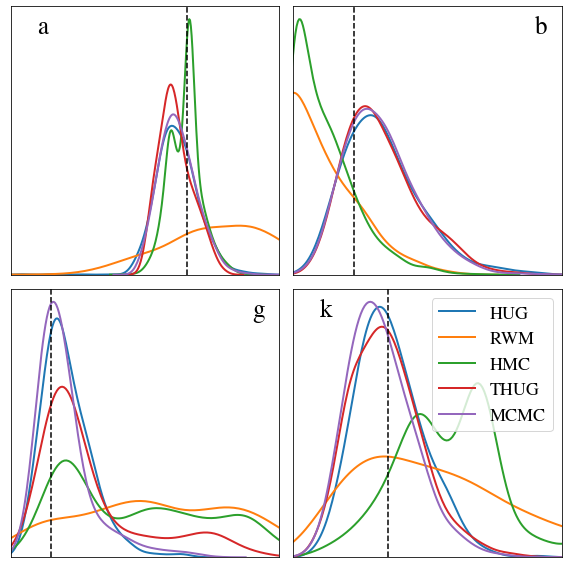

In [54]:
SMOOTH = 0.3
LABELS = ['a', 'b', 'g', 'k']
LW = 2
FROM = 0
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for i in range(4):
    # Pure Hug, QR projection
    _ = sns.kdeplot(sHUG[FROM:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='HUG', lw=LW)
    # Pure Hug, Linear Solver projection
    #_ = sns.kdeplot(samples2[:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='Hug LN {:.1%}'.format(acceptances2.mean()))
    # RWM
    _ = sns.kdeplot(sRWM[FROM:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='RWM', lw=LW)
    # HMC 
    #_ = sns.kdeplot(samples4a[:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='HMC {:.1%}'.format(acceptances4a.mean()))
    _ = sns.kdeplot(sHMC[FROM:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='HMC', lw=LW)
    # THUG, QR projection
    _ = sns.kdeplot(sTHUG[FROM:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='THUG', lw=LW)
    # True
    #_ = sns.kdeplot(strueI[:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='MCMC I {:.1%}'.format(atrueI))
    #_ = sns.kdeplot(strueΣ[:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='MCMC Σ {:.1%}'.format(atrueΣ))
    # THUG 0.99 ON TINY EPSILON
    #_ = sns.kdeplot(S099[:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='THUG'.format(AP099/100))
    # Prangle samples
    _ = sns.kdeplot(prangle_mcmc_samples[:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='MCMC', lw=LW)
    
    # Prettify
    ax[i // 2, i % 2].axvline(θ0[i], c='k', ls='--')
#     ax[i // 2, i % 2].set_xlabel(r'${}$'.format(LABELS[i]), fontsize=20)
    # Remove the xlabel if (0, 1) or (1, 1)
    if i % 2 == 1:
        ax[i // 2, i % 2].set_ylabel("")
    
    # Set axes limits to the min, max of HUG/THUG
    ax[i // 2, i % 2].set_xlim([min(sHUG[:, i].min(), sTHUG[:, i].min())-0.1, max(sHUG[:, i].max(), sTHUG[:, i].max()) + 0.1])
    ax[i // 2, i % 2].set_ylabel("")
    ax[i // 2, i % 2].set_yticks([])
    ax[i // 2, i % 2].set_xticks([])
    x_pos = 0.1 if (i // 2 == i % 2) else 0.9
    ax[i // 2, i % 2].text(x_pos, 0.9, "{}".format(LABELS[i]), transform=ax[i //2, i % 2].transAxes, fontsize=25, fontfamily='STIXGeneral')
#fig.suptitle(r'$\epsilon$ = {}'.format(ϵ), fontsize=20)
plt.tight_layout()
plt.legend(prop={'family':'STIXGeneral', 'size':18})
#plt.savefig("figures/gk_eps10m3.png", dpi=300)
# plt.savefig("figures/gk_best_epsilon.png", dpi=300)
plt.show()